# Bank customer churn model with Neural Network (Keras)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

import missingno as msno

import seaborn as sns
sns.set(style='white')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [1]:
from subprocess import check_output
#print(check_output(["ls", "data/"]).decode("utf8"))

## Data collection

In [3]:
df_raw = pd.read_csv(
    "data/bank-customer-data.csv"
)

In [4]:
df_raw.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [5]:
df = df_raw.copy()

In [52]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

## Data preprocesing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Visualisation of where missing values are in the dataset (if there are any)

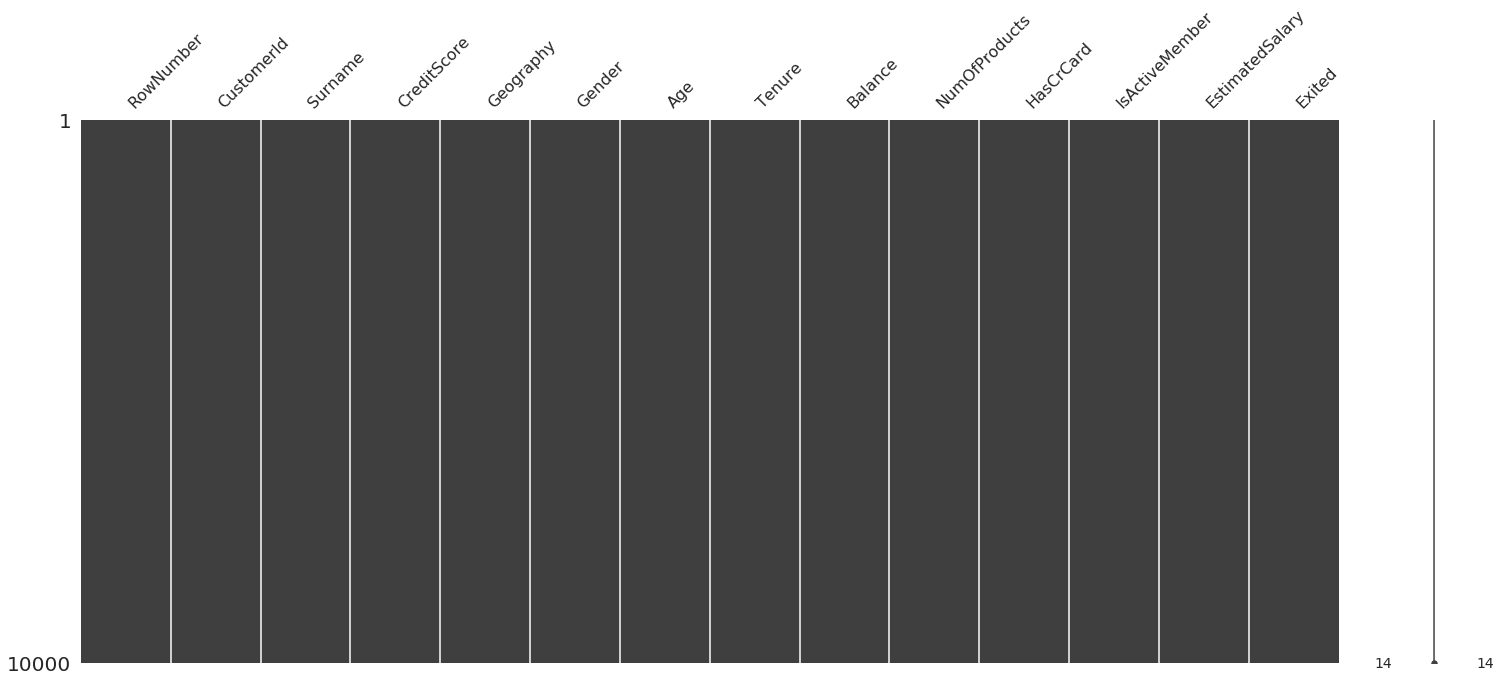

In [7]:
msno.matrix(df)

#### Removing the irrelevant columns

In [8]:
cols_to_drop = ["RowNumber","CustomerId","Surname"]
df = df.drop(columns=cols_to_drop,axis=1)

#### Inspecting data for biases

In [9]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

#### Inspecting the balance

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

In [10]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

#### Decting and removing potential outlines

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


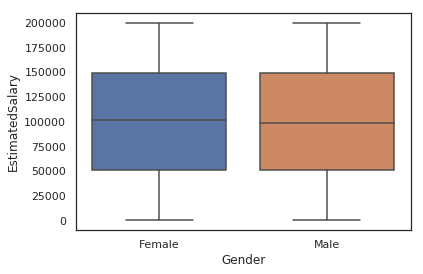

In [12]:
sns.boxplot(x="Gender", y="EstimatedSalary", data=df)

## Feature engineering

### Inspecting features

Inspecting the dataframe will show that serveral of the columns can be considered as categorial nominal features.

In [13]:
fmt = '{:<20} {}'
for col_name in df:
    print(fmt.format(col_name, df[col_name].unique()))

CreditScore          [619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799
 602 744 588 747 583 627 731 629 438 642 806 474 559 429 680 749 734 644
 626 649 805 718 840 630 654 762 568 613 522 737 648 443 640 540 460 593
 801 611 802 745 483 690 492 7

In [14]:
features = df.iloc[:, 0:10]
labels = df.iloc[:, -1]

In [15]:
def convert_has_creditcard(val):
    if(val == 1):
        return 'Yes'
    else:
        return 'No'

features['HasCrCard'] = features['HasCrCard'].apply(convert_has_creditcard)

In [16]:
def convert_age_segmentaion(val):
    if(val <= 10):
        return 'Age 0-10'
    elif(val <= 20):
        return 'Age 11-20'
    elif(val <= 30):
        return 'Age 21-30'
    elif(val <= 40):
        return 'Age 31-40'
    elif(val <= 50):
        return 'Age 41-50'
    elif(val <= 60):
        return 'Age 51-60'
    elif(val <= 70):
        return 'Age 61-70'
    elif(val <= 80):
        return 'Age 71-80'
    
    return 'Age 80+'

features['Age'] = features['Age'].apply(convert_age_segmentaion)

#### Categorical attributes

Typically, any data attribute which is categorical in nature represents discrete values. These discrete values can be text or numeric in nature (or even unstructured data like images!)

In [17]:
categorical_nominal_features = [   
    'Gender',
    'Age',
    'Geography',
    'HasCrCard'
]

features = pd.get_dummies(features, columns = categorical_nominal_features)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
CreditScore          10000 non-null int64
Tenure               10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Gender_Female        10000 non-null uint8
Gender_Male          10000 non-null uint8
Age_Age 11-20        10000 non-null uint8
Age_Age 21-30        10000 non-null uint8
Age_Age 31-40        10000 non-null uint8
Age_Age 41-50        10000 non-null uint8
Age_Age 51-60        10000 non-null uint8
Age_Age 61-70        10000 non-null uint8
Age_Age 71-80        10000 non-null uint8
Age_Age 80+          10000 non-null uint8
Geography_France     10000 non-null uint8
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
HasCrCard_No         10000 non-null uint8
HasCrCard_Yes        10000 non-null uint8
dtypes

## Correlations between customer data features and customer churn

In [18]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

### Correlation matrix
Inspecting features for potential good and bad features

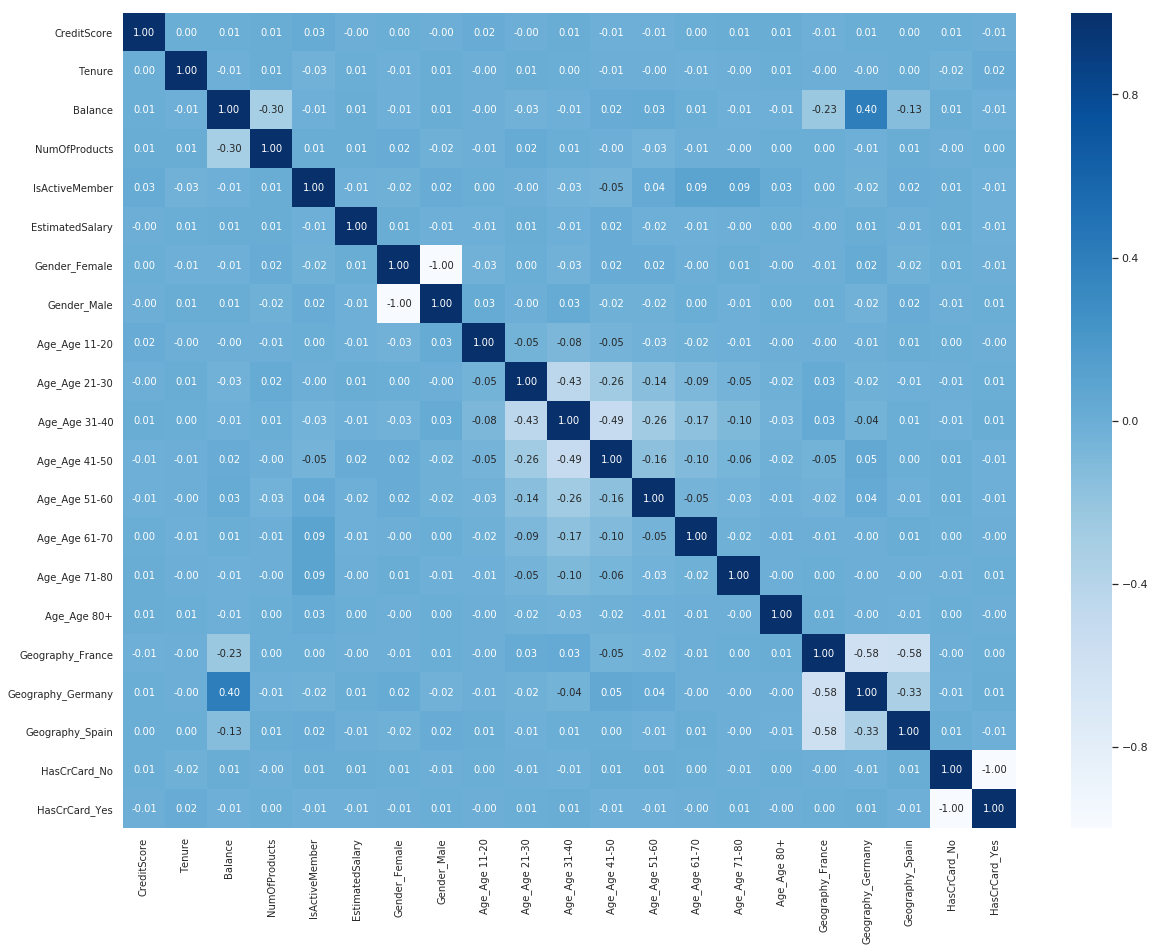

In [19]:
corr = features.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, fmt='.2f', annot = True, cmap="Blues", annot_kws={'size':10})

heat_map = plt.gcf()
heat_map.set_size_inches(20,15)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [20]:
x = features.values
y = labels.values

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [30]:
sc = StandardScaler()

In [31]:
X_train = sc.fit_transform(X_train)

In [32]:
X_test = sc.transform(X_test)

## Baseline for Customer Churn with Logistic Regression

In [33]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

/Users/markjensen/anaconda3/envs/keras-dev/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


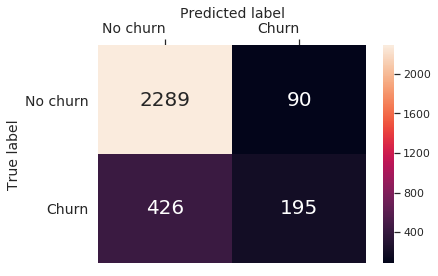

In [34]:
cfm = confusion_matrix(y_test, y_pred)
df_confusion_matrix = pd.DataFrame(cfm, ('No churn', 'Churn'), ('No churn', 'Churn'))

heatmap = sns.heatmap(df_confusion_matrix, annot=True, annot_kws={"size": 20}, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticks_position('top')
heatmap.xaxis.set_label_position('top')

plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

plt.show()

https://www.python-course.eu/confusion_matrix.php

#### Accuracy - overall, how often is the classifier correct
Can also be calculated using *"metrics.accuracy_score(y_test, y_pred)"*

In [46]:
(2289 + 195) / (3000)

0.828

#### Misclassification Rate - Overall, how often is it wrong?
This also known as "Error Rate"

In [48]:
(426 + 90) / (3000)

0.172

#### Prevalence - How often does the "churn" condition actually occur in our sample?

In [50]:
(426 + 195) / (3000)

0.207

#### Classification report

* **Precision** - The fraction of predicted positives events that are actually positive (e.g. when it predicts "churn", how often is it correct?)
* **Recall** (aka sensitivity or true positive rate): Fraction of positives that were correctly identified (e.g. when it's actually "churn", how often does it predict "churn"?)
* **F1-score** - A helpful metric for comparing two classifiers. F1 Score takes into account precision and the recall (a higher score equals a better model)

In [37]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      2379
           1       0.68      0.31      0.43       621

   micro avg       0.83      0.83      0.83      3000
   macro avg       0.76      0.64      0.66      3000
weighted avg       0.81      0.83      0.80      3000



#### Interpretating the results

* Precision - When the model predicts that a customer will churn, it correctly predicts it 68% of the time
* Recall - When the model **correctly** predicts that customer will churn, it correctly predcits it 31% of the time

So while accuracy is 82%, the model only predicts 31% of the churned customers correctly

#### ROC Curve

Receiver Operating Characteristic(ROC) curves are VERY help with understanding the balance between true-positive rate and false positive rates.

The following plot shows the tradeoff between sensitivity and specificity (e.g True Positive Rate and True Negative Rate).

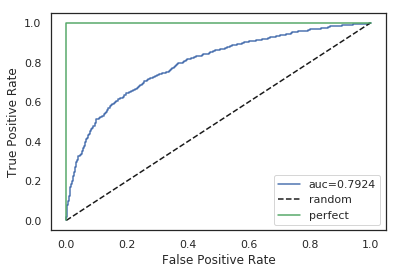

In [51]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="auc="+str(round(auc, 4)))
plt.plot([0,1],[0,1],'k-',label='random', linestyle='--')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc=4)
plt.show()

#### Additional resources

* [Understanding Data Science Classification Metrics in Scikit-Learn in Python](https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019)
* [Metrics – Classification Report Breakdown (Precision, Recall, F1)](http://joshlawman.com/metrics-classification-report-breakdown-precision-recall-f1/)

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

https://mdatascience.gitbook.io/ifv/part-2-people-analytics/2.1-advanced-identification-of-influential-features-for-customers-churn-predictions-part-i

# Using Neural Network to predict Customer Churn
model_training = model.fit(
    X_train, 
    y_train, 
    validation_split=0.3, 
    batch_size = 10, 
    epochs=100, 
    callbacks=[early_stopping_monitor]
)

In [175]:
def create_keras_model(optimizer='rmsprop', init='glorot_uniform'):

    # Define early_stopping_monitor
    early_stopping_monitor = EarlyStopping(patience=3)

    model = Sequential()
    
    # Adding the input layer and the first hidden layer
    model.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 21))
    #model.add(Dropout(rate=0.1))

    # Adding the second hidden layer
    model.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    #model.add(Dropout(rate=0.1))

    # Adding the output layer
    model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

    # Compiling the ANN
    # optimiers = adam, rmsprop, adagrad, adadelta, sgd
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

    # Fitting the ANN to the Training set
    #classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

    return model

np.random.seed(1337) # for reproducibility

clf = KerasClassifier(
    build_fn=create_keras_model, 
    batch_size=10, 
    epochs=100,
    verbose = 0 # 0 = nothing, 1 = progressbar, 2 =  epochs only
)

In [176]:
print(clf.build_fn().summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_871 (Dense)            (None, 6)                 132       
_________________________________________________________________
dense_872 (Dense)            (None, 6)                 42        
_________________________________________________________________
dense_873 (Dense)            (None, 1)                 7         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
None


#### Hyperparameters

In [177]:
# grid search epochs, batch size
optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

epochs = [50] #range(5, 30, 10) #[1, 10] # add 50, 100, 150 etc

batch_size = [10, 20, 30] #[3,4,5,6,7,8,9,10] # add 5, 10, 20, 40, 60, 80, 100 etc

hyperparameters = dict(
    epochs = epochs, 
    batch_size = batch_size,
    optimizer = optimizer
)

#### GridSearchCV

In [178]:
%%time

grid_search = GridSearchCV(estimator=clf, param_grid = hyperparameters, cv = 3, scoring='accuracy')

grid_result = grid_search.fit(X_train, y_train) 

print('Done...')

Done...
CPU times: user 2h 28min, sys: 15min 29s, total: 2h 43min 30s
Wall time: 2h 15min 14s


In [179]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.854571 using {'batch_size': 10, 'epochs': 50, 'optimizer': 'SGD'}
0.854571 (0.003873) with: {'batch_size': 10, 'epochs': 50, 'optimizer': 'SGD'}
0.834571 (0.011213) with: {'batch_size': 10, 'epochs': 50, 'optimizer': 'RMSprop'}
0.802429 (0.011225) with: {'batch_size': 10, 'epochs': 50, 'optimizer': 'Adagrad'}
0.834286 (0.015163) with: {'batch_size': 10, 'epochs': 50, 'optimizer': 'Adadelta'}
0.827000 (0.002461) with: {'batch_size': 10, 'epochs': 50, 'optimizer': 'Adam'}
0.833714 (0.007824) with: {'batch_size': 10, 'epochs': 50, 'optimizer': 'Adamax'}
0.832857 (0.007609) with: {'batch_size': 10, 'epochs': 50, 'optimizer': 'Nadam'}
0.805571 (0.015661) with: {'batch_size': 20, 'epochs': 50, 'optimizer': 'SGD'}
0.831714 (0.011715) with: {'batch_size': 20, 'epochs': 50, 'optimizer': 'RMSprop'}
0.809571 (0.012188) with: {'batch_size': 20, 'epochs': 50, 'optimizer': 'Adagrad'}
0.839000 (0.014379) with: {'batch_size': 20, 'epochs': 50, 'optimizer': 'Adadelta'}
0.824429 (0.003633) with:

#### RandomizedSearchCV

In [76]:
%%time

n_iter_search = 16 # Number of parameter settings that are sampled.

random_search = RandomizedSearchCV(
    estimator = clf, 
    param_distributions = hyperparameters, 
    n_iter = n_iter_search,
    cv = 3, 
    scoring='accuracy'
)

random_result = random_search.fit(X_train, y_train) 

print('Done...')

Done...


In [77]:
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.836000 using {'optimizer': 'Nadam', 'epochs': 10, 'batch_size': 20}
0.823375 (0.002743) with: {'optimizer': 'RMSprop', 'epochs': 10, 'batch_size': 20}
0.796000 (0.003717) with: {'optimizer': 'SGD', 'epochs': 10, 'batch_size': 30}
0.827375 (0.004578) with: {'optimizer': 'Adamax', 'epochs': 10, 'batch_size': 10}
0.796000 (0.003717) with: {'optimizer': 'Adagrad', 'epochs': 10, 'batch_size': 30}
0.810750 (0.013574) with: {'optimizer': 'RMSprop', 'epochs': 10, 'batch_size': 30}
0.832875 (0.002774) with: {'optimizer': 'Adadelta', 'epochs': 10, 'batch_size': 20}
0.825750 (0.004050) with: {'optimizer': 'Adam', 'epochs': 10, 'batch_size': 20}
0.836000 (0.007891) with: {'optimizer': 'Nadam', 'epochs': 10, 'batch_size': 20}
0.796000 (0.003717) with: {'optimizer': 'Adagrad', 'epochs': 10, 'batch_size': 20}
0.831375 (0.001783) with: {'optimizer': 'Adadelta', 'epochs': 10, 'batch_size': 10}
0.827125 (0.001710) with: {'optimizer': 'RMSprop', 'epochs': 10, 'batch_size': 10}
0.796000 (0.003717)

#### Extract best model

In [181]:
model = grid_result.best_estimator_.model

#### Model performance

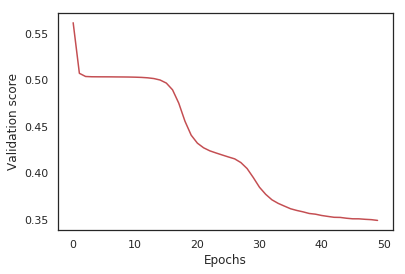

Test loss: 0.3444891813652856
Test accuracy: 0.86


In [182]:
# Visual representation of how the model performed during traning
plt.plot(grid_result.best_estimator_.model.history.history['loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

score = model.evaluate(X_train, y_train, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [183]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

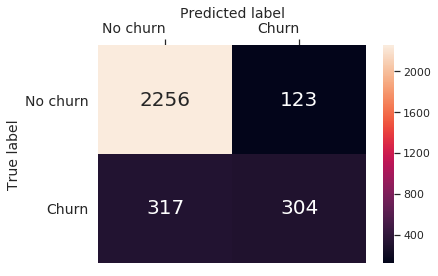

In [186]:
cfm = confusion_matrix(y_test, y_pred)
df_confusion_matrix = pd.DataFrame(cfm, ('No churn', 'Churn'), ('No churn', 'Churn'))

heatmap = sns.heatmap(df_confusion_matrix, annot=True, annot_kws={"size": 20}, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticks_position('top')
heatmap.xaxis.set_label_position('top')

plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

plt.show()

In [185]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2379
           1       0.71      0.49      0.58       621

   micro avg       0.85      0.85      0.85      3000
   macro avg       0.79      0.72      0.75      3000
weighted avg       0.84      0.85      0.84      3000



In [ ]:
y_pred_proba = model.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="auc="+str(round(auc, 4)))
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc=4)
plt.show()

In [88]:
(1543 + 141) / (1543 + 52 + 264 + 141) 

0.842

In [112]:
"SGD", (1512 + 202) / (2000)

('SGD', 0.857)

In [107]:
"Adadelta", (1508 + 210) / (2000)

('Adadelta', 0.859)